# Chapter 3 | Linear Neural Network

In [5]:
import random
import math
import time
import numpy as np
import torch
from d2l import torch as d2l
%matplotlib inline

## 3.1 Linear Regression

### 3.1.3 The Normal Distribution and Squared Loss

In [2]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

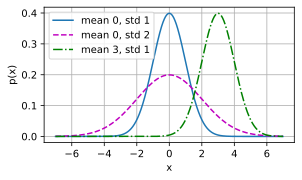

In [3]:
x = np.arange(-7, 7, 0.01)

params = [(0, 1), (0, 2), (3, 1)] # mean and standard deviation pairs
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel = 'x',
         ylabel = 'p(x)', figsize = (4.5, 2.5),
         legend = [f'mean {mu}, std {sigma}' for mu, sigma in params])

## 3.2 Linear Regression Implementation from Scratch

### 3.2.1 Generating the Dataset

In [9]:
## generate synthetic data
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b          # linear regression
    y += torch.normal(0, 0.01, y.shape) # noise
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 0.0346, -0.5985]) 
label: tensor([6.3020])


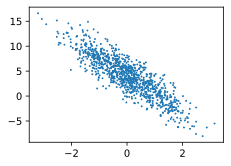

In [10]:
## plotting
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

### 3.2.2 Reading the Dataset

In [15]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    
    random.shuffle(indices) ## examples are read at random
    
    for i in range(0 ,num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [16]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0770, -1.0281],
        [ 0.2412, -0.7819],
        [ 0.5398,  0.0130],
        [-0.4067,  0.6112],
        [-0.0080,  0.1479],
        [ 0.7315, -0.3205],
        [ 0.0346, -0.5985],
        [-1.1141,  1.5195],
        [ 0.3011, -0.3665],
        [-1.3526,  0.0556]]) 
 tensor([[ 7.8553],
        [ 7.3206],
        [ 5.2434],
        [ 1.2923],
        [ 3.6800],
        [ 6.7408],
        [ 6.3020],
        [-3.1823],
        [ 6.0473],
        [ 1.3142]])


### 3.2.3 Initializing Model Parameters

In [17]:
## initialize parameters
w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad= True)

### 3.2.4 Defining the Model

In [19]:
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

### 3.2.5 Defining the Loss Function

In [20]:
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape))**2/2

### 3.2.6 Defining the Optimization Algorithm

In [23]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7 Training 

In [24]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) ## minibatch loss in X and y
        
        l.sum().backward() ## compute gradient on l with respect to w and b
        sgd([w, b], lr, batch_size) ## update parameters using the gradient
    
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f"epoch {epoch + 1}, loss {float(train_l.mean()):f}")

epoch 1, loss 0.040834
epoch 2, loss 0.000165
epoch 3, loss 0.000047


In [25]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([ 0.0006, -0.0005], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0007], grad_fn=<RsubBackward1>)


## 3.3 Concise Implementation of Linear Regression

### 3.3.1 Generating the Dataset

In [26]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

In [27]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 Reading the Dataset

In [28]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [29]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

### 3.3.3 Defining a Model

In [30]:
from torch import nn

net = nn.Sequential(nn.Linear(in_features = 2, out_features = 1))

### 3.3.4 Initializing Model Parameters

In [38]:
net[0].weight.data.normal_(0, 0.01) ## weight sampled from a normal distribution
net[0].bias.data.fill_(0) ## bias = 0

tensor([0.])

### 3.3.5 Defining the Loss Function

In [39]:
loss = nn.MSELoss()

### 3.3.6 Defining the Optimization Algorithm

In [40]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

### 3.3.7 Training

In [41]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y) ## calculate loss 
        trainer.zero_grad() ## calculate gradient
        l.backward() ## backpropagation
        trainer.step() ## update the model parameter
    l = loss(net(features), labels)
    print(f"epoch {epoch + 1}, loss {l:f}")

epoch 1, loss 0.000348
epoch 2, loss 0.000098
epoch 3, loss 0.000098


In [42]:
w = net[0].weight.data
print('error in estimating w: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b: ', true_b - b)

error in estimating w:  tensor([-2.6703e-04,  2.2888e-05])
error in estimating b:  tensor([0.0002])


## 3.5 The Image Classification Dataset

In [43]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

%matplotlib inline
d2l.use_svg_display()

### 3.5.1 Reading the Dataset

In [44]:
trans = transforms.ToTensor() # convert image data from PIL type to 32-bit floating point and divides all numbers by 255
mnist_train = torchvision.datasets.FashionMNIST(root = '../data', train = True, transform = trans, download = True)
mnist_test = torchvision.datasets.FashionMNIST(root = '../data', train = False, transform = trans, download = True)

100.0%


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100.6%


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100.0%


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



119.3%

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [45]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [46]:
mnist_train[0][0].shape # height and width of the input image are both 28 pixels

torch.Size([1, 28, 28])

In [47]:
## convert labels
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 
                  'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [57]:
def show_images(imgs, num_rows, num_cols, titles = None, scale = 1.5):
    """Plot a list of images"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize = figsize)
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image: transform to numpy
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

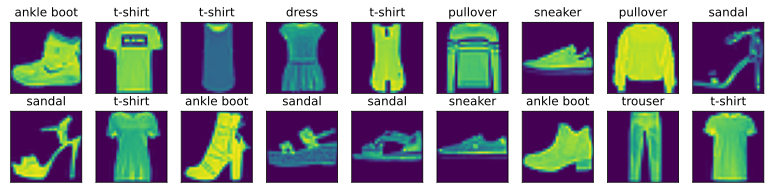

In [58]:
## Show images
X, y = next(iter(data.DataLoader(mnist_train, batch_size = 18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles = get_fashion_mnist_labels(y));

### 3.5.2 Reading a Minibatch

In [59]:
batch_size = 256

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers = get_dataloader_workers())

In [60]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'7.40 sec'

### 3.5.3 Putting All Things Together

In [65]:
def load_data_fashion_mnist(batch_size, resize = None):
    """Download the Fashion-MNIST dataset and then load it into memory"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root = '../data', train=True, transform = trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root = '../data', train=False, transform = trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers = get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers = get_dataloader_workers()))

In [67]:
train_iter, test_iter = load_data_fashion_mnist(32, resize = 64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


## 3.6 Implementation of Softmax Regression from Scratch

In [68]:
import torch
from IPython import display
from d2l import torch as d2l

In [69]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.6.1 Initializing Model Parameters

In [70]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad = True)

### 3.6.2 Defining the Softmax Operation

In [72]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim = True)
    return X_exp / partition

### 3.6.3 Defining the Model

In [73]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, w.shape[0])), w) + b)

### 3.6.4 Defining the Loss Function

In [74]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

### 3.6.5 Classification Accuracy

In [75]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis = 1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [76]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [77]:
class Accumulator:
    """For accumulating sums over 'n' variables."""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    
    def reset(self):
        self.data = [0.0] * len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

### 3.6.6 Training 

In [78]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3"""
    # set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    
    for X, y in train_iter:
        # compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # use pytorch in-built function
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # use the custom built optimizer and loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(flat(l.sum()), accuracy(y_hat, y), y.numel())
    
    # return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

## 3.7 Concise Implementation of Softmax Regression

In [80]:
import torch 
from torch import nn
from d2l import torch as d2l

In [81]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

### 3.7.1 Initializing Model Parameters

In [84]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std = 0.01)

net.apply(init_weights);

### 3.7.2 Softmax Implementation

In [85]:
loss = nn.CrossEntropyLoss(reduction='none')

### 3.7.3 Optimization Algorithm

In [87]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

### 3.7.4 Training

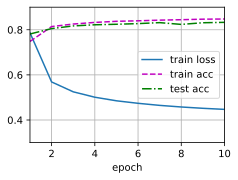

In [88]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [105]:
t1 = torch.tensor([[1, -1], [-1, 3]])
t2 = torch.tensor([[2, 3, 0]])

In [112]:
t1.flatten()

tensor([ 1, -1, -1,  3])

In [116]:
t2.flatten()

tensor([2, 3, 0])

In [118]:
torch.concat((t1.flatten(), t2.flatten()), dim = 0)

tensor([ 1, -1, -1,  3,  2,  3,  0])

In [93]:
my_tensor, idx_tensor

(tensor([ 2,  3, -1, 10]), tensor([0, 1, 2, 3]))

In [104]:
torch.cat((idx_tensor.unsqueeze(0), my_tensor.unsqueeze(0)), dim = 0).T

tensor([[ 0,  2],
        [ 1,  3],
        [ 2, -1],
        [ 3, 10]])

In [102]:
idx_tensor.unsqueeze(0)

tensor([[0],
        [1],
        [2],
        [3]])

In [97]:
torch.cat((idx_tensor.T, my_tensor.T), dim = 0)

tensor([ 0,  1,  2,  3,  2,  3, -1, 10])